# 1. Import the libraries and read the data

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import pandas as pd

In [4]:
# Read the data
data = pd.read_csv('price_data_2018_2020.csv',index_col=0)
# Convert the date to date-time format
data.index = pd.to_datetime(data.index)
# Calculate the daily percentage changes of the prices
data_pc = data.pct_change()
data_pc.tail()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-08,0.019006,-0.003085,-0.003087,-0.006690,0.007749,0.000547,0.001990,0.023869,0.043809,0.061881,...,0.092211,0.005837,0.046163,0.028781,-0.008655,0.018676,0.038741,0.020603,0.038891,0.009900
2020-05-11,-0.018719,0.025294,0.046927,0.040306,-0.004296,0.031720,0.010639,0.047941,0.008731,-0.036519,...,-0.049114,-0.002985,-0.030336,-0.004720,-0.007460,0.002205,-0.031533,-0.031758,-0.049154,0.007332
2020-05-12,-0.028889,-0.023629,0.029124,-0.017060,-0.010812,-0.042539,-0.017016,-0.035522,-0.011434,0.005645,...,-0.048506,-0.022285,-0.038680,-0.024283,-0.055333,-0.027440,-0.021508,-0.037291,-0.047244,-0.018831
2020-05-13,-0.038157,-0.017484,-0.017577,-0.029745,-0.025415,0.019654,-0.017913,-0.029390,-0.042249,-0.068966,...,-0.024028,-0.012417,-0.090533,-0.022744,-0.014559,-0.042381,-0.030930,-0.022185,-0.054617,-0.007903
2020-05-14,-0.000955,-0.004123,0.012040,-0.007166,-0.005580,-0.009638,-0.008841,0.044653,0.015850,0.018088,...,0.019930,0.002411,0.001301,0.029487,0.012713,0.035430,-0.005872,0.009273,0.046750,0.024384


# 2. Calculate the standard deviation

In [5]:
# Calculate the standard deviation
data_std = data_pc.loc[:'2018-12-31'].std()*(252**0.5)*100
data_std.tail()

YUM     19.627587
ZBRA    40.399247
ZBH     23.342641
ZION    25.028016
ZTS     23.517628
dtype: float64

# 3. Top volatility decile potfolio

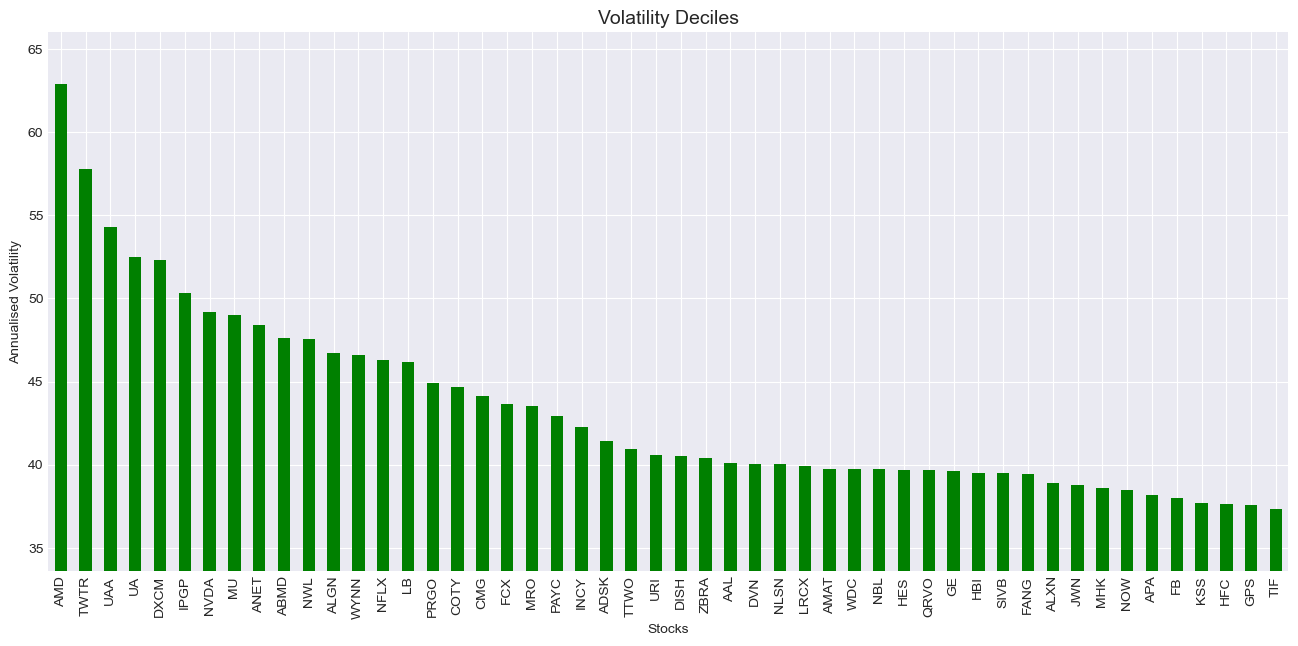

In [6]:
vol_sorted = data_std.sort_values(ascending=False)
top_decile = vol_sorted[:int(len(data_std)*0.1)]
top_decile.plot.bar(figsize=(16,7),color='green',ylim=top_decile.min()*0.9)
plt.title('Volatility Deciles', fontsize=14)
plt.xlabel('Stocks')
plt.ylabel('Annualised Volatility')
plt.show()

# 4. Form the portfolio

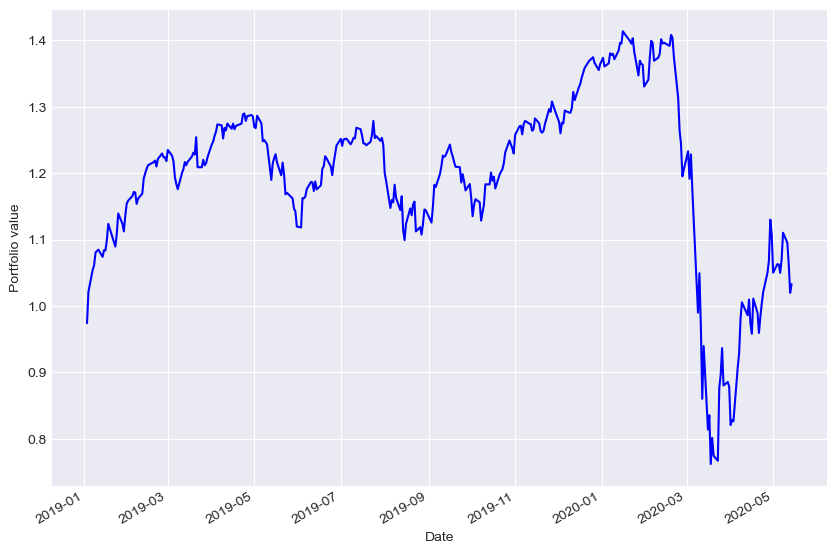

In [7]:
# Retrieve data in stock_list from 2019 January onwards
stock_data = data.loc['2019-1':,top_decile.index]
# Calculate the daily percentage change of prices
stock_data_pc = stock_data.pct_change()
# Create a new dataframe called portfolio
portfolio = pd.DataFrame()
# Calculate the average returns of stocks
portfolio['returns'] = stock_data_pc.mean(axis=1)
# Calculate cumulative returns of portfolio
portfolio['value'] = (portfolio+1).cumprod()
# Drop any rows with nan values
portfolio = portfolio.dropna()
portfolio.value.plot(color='b',figsize=(10,7))
plt.ylabel("Portfolio value")
plt.show()

# 5. Trading signals and performance analytics: Moving Average

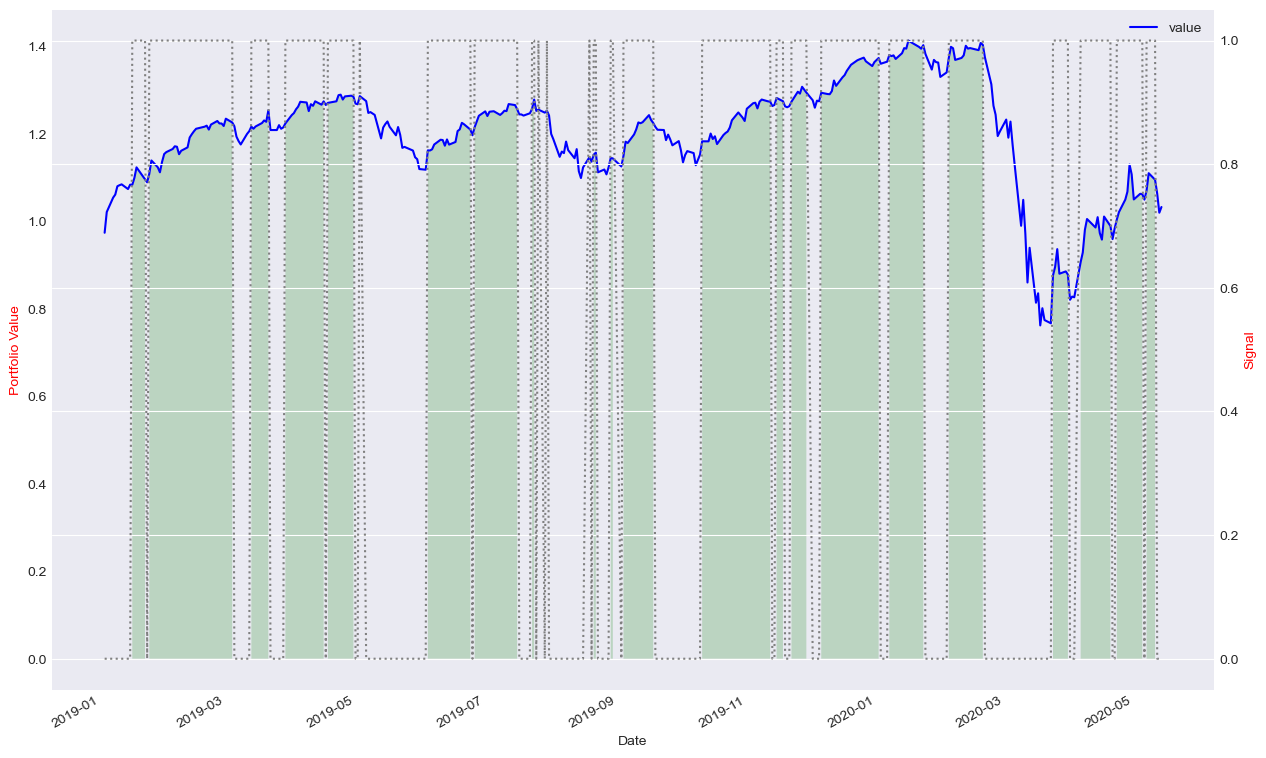

In [9]:
def get_strategy_returns_sma(portfolio):
    # Calculate the simple moving average of period 10
    portfolio['sma10'] = portfolio.value.rolling(window=10).mean()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value > portfolio.sma10,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)      
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()

portfolio = get_strategy_returns_sma(portfolio)    
plot_signal(portfolio) 

The Sharpe ratio is 1.14 


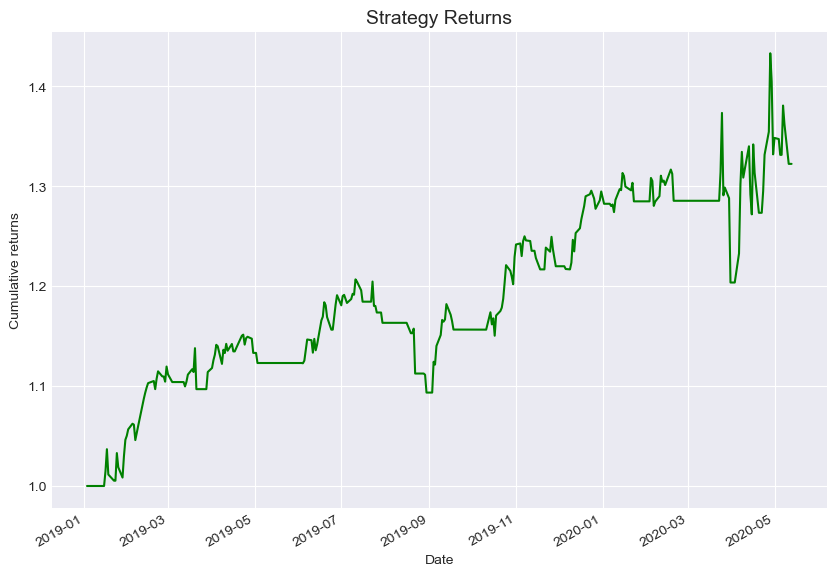

The maximum drawdown is -12.36


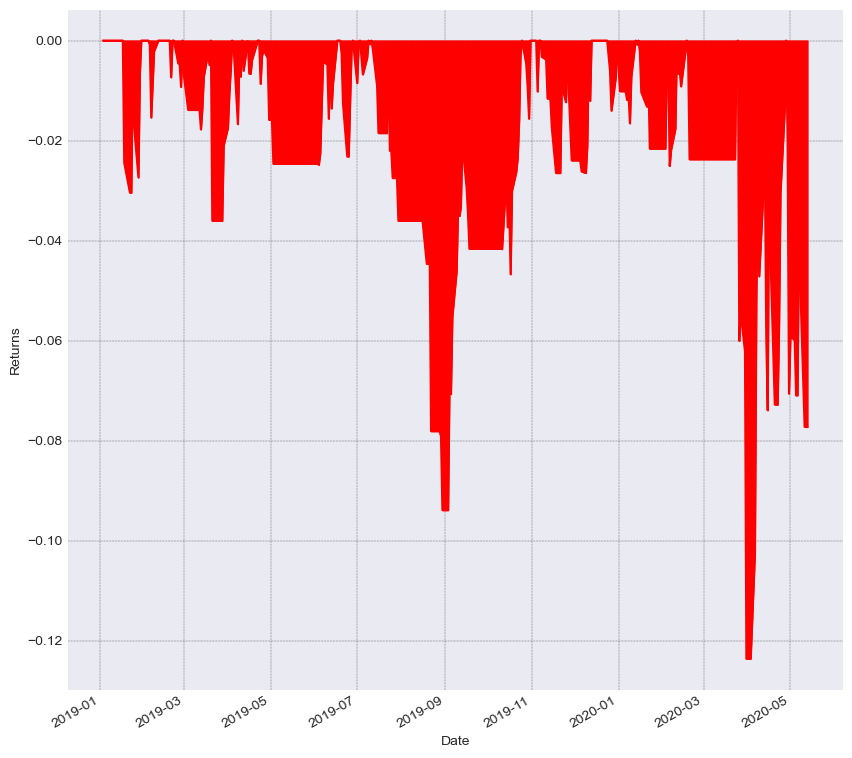

In [10]:
# Plot the portfolio returns
def plot_returns_dd(portfolio):
    # ----------- Sharpe ratio ------------------
    sharpe_ratio = np.mean(portfolio.str_returns)/np.std(portfolio.str_returns)*(252**0.5)
    print('The Sharpe ratio is %.2f ' % sharpe_ratio)

    # ----------- Cumulative strategy returns ------------------
    portfolio['cum_str_returns'] = (portfolio['str_returns']+1).cumprod()
    # Plot the cumulative strategy returns
    portfolio['cum_str_returns'].plot(figsize=(10,7), color='green')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()        

    # ----------- Drawdown ------------------    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    print('The maximum drawdown is %.2f' % max_dd)
    # Plot the drawdowns
    drawdown.plot(color='r',figsize=(10,10))
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()    
    
plot_returns_dd(portfolio) 

# 6. Trading signals and performance analytics: Breakout

In [11]:
portfolio

,returns,value,sma10,signal,str_returns,cum_str_returns
Date,,,,,,
2019-01-03,-0.025996,0.974004,NaN,0,0.000000,1.000000
2019-01-04,0.048774,1.021511,NaN,0,0.000000,1.000000
2019-01-07,0.032166,1.054369,NaN,0,0.000000,1.000000
2019-01-08,0.006580,1.061307,NaN,0,0.000000,1.000000
2019-01-09,0.017985,1.080394,NaN,0,0.000000,1.000000
...,...,...,...,...,...,...
2020-05-08,0.037074,1.110235,1.076133,1,-0.013531,1.362241
2020-05-11,-0.013531,1.095212,1.080667,1,-0.029155,1.322525
2020-05-12,-0.029155,1.063282,1.080197,0,-0.000000,1.322525


The Sharpe ratio is 1.48 


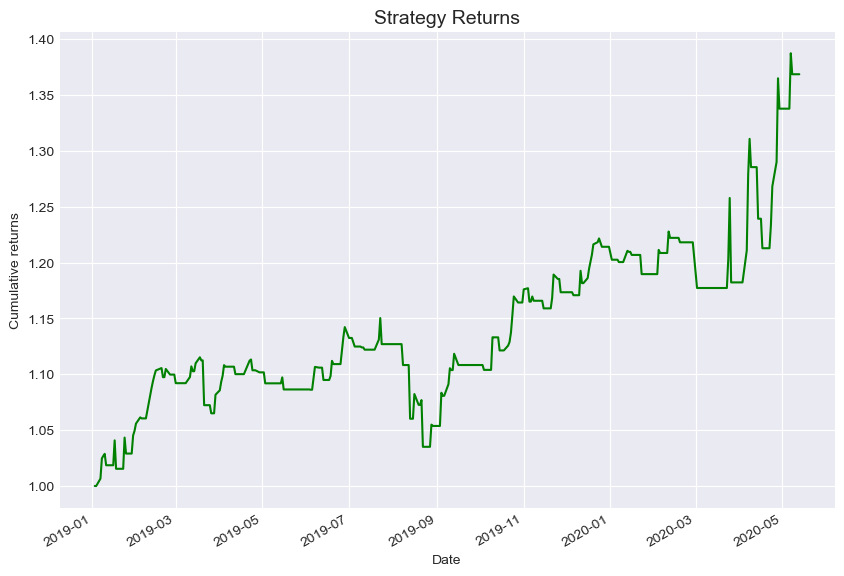

The maximum drawdown is -10.02


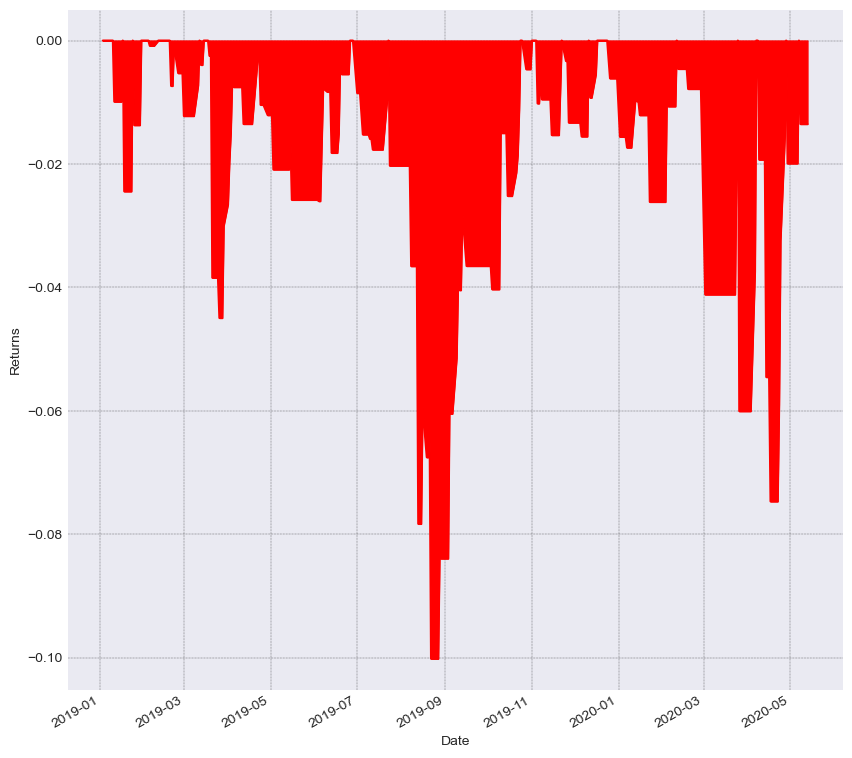

In [12]:
def get_strategy_returns_breakout(portfolio):
    # Calculate the breakout indicator values
    portfolio['high'] = portfolio.value.rolling(window=3).max()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value>=portfolio.high,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_breakout(portfolio)
# plot_signal(portfolio)    
plot_returns_dd(portfolio) 

In [13]:
portfolio.tail(20)

,returns,value,sma10,signal,str_returns,cum_str_returns,high
Date,,,,,,,
2020-04-17,0.055069,1.011085,0.958694,1,-0.021317,1.212825,1.011085
2020-04-20,-0.021317,0.989532,0.974998,0,-0.000000,1.212825,1.011085
2020-04-21,-0.030364,0.959486,0.980257,0,0.000000,1.212825,1.011085
2020-04-22,0.025559,0.984010,0.985781,0,0.000000,1.212825,0.989532
2020-04-23,0.020342,1.004027,0.988097,1,0.017022,1.233470,1.004027
2020-04-24,0.017022,1.021117,0.989664,1,0.028163,1.268208,1.021117
2020-04-27,0.028163,1.049874,0.996048,1,0.017250,1.290084,1.049874
2020-04-28,0.017250,1.067984,1.001881,1,0.058026,1.364943,1.067984
2020-04-29,0.058026,1.129955,1.017538,1,-0.019920,1.337753,1.129955


# 7. Trading signals and performance analytics: Moving average and breakout

The Sharpe ratio is 1.58 


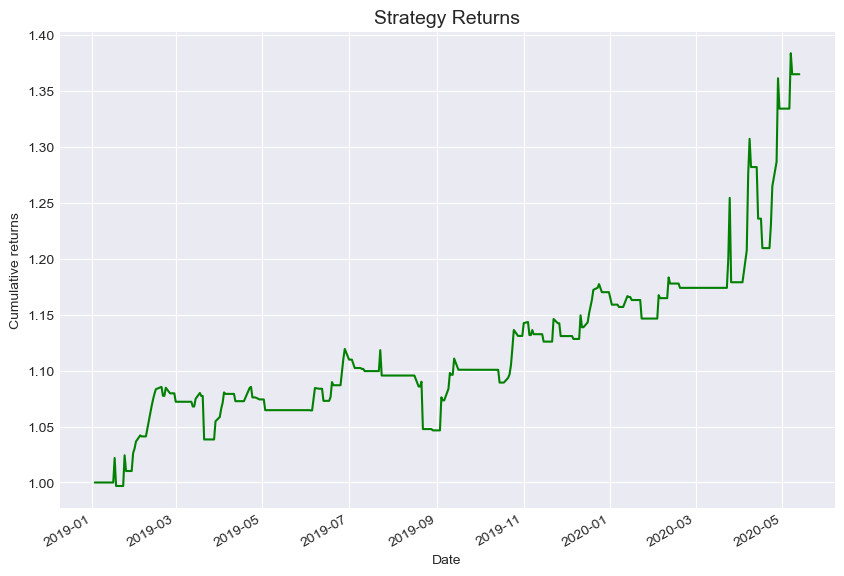

The maximum drawdown is -7.47


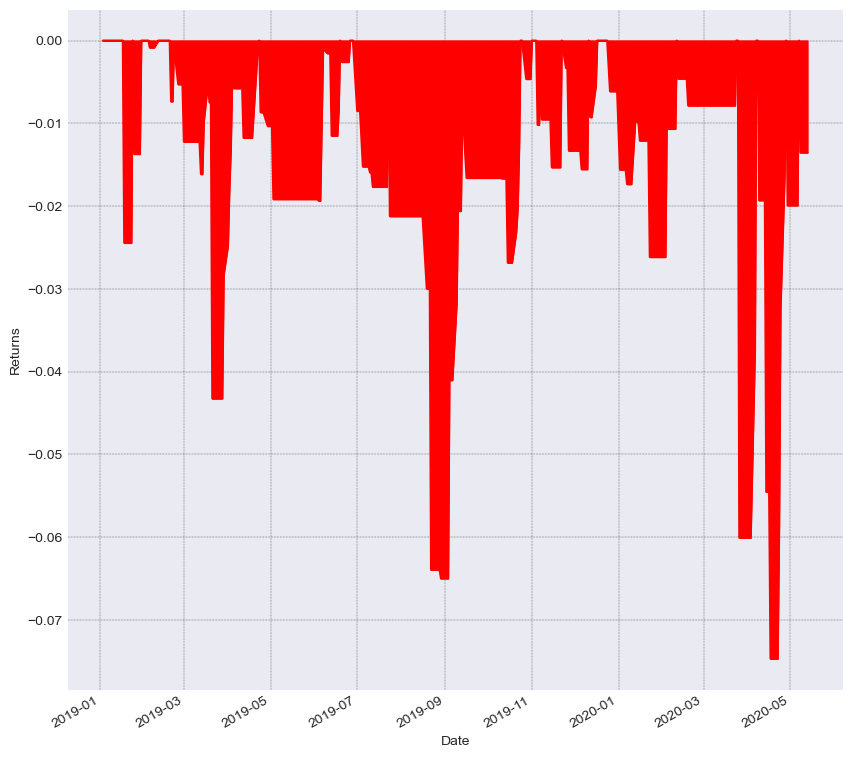

In [14]:
def get_strategy_returns_sma_breakout(portfolio):
    # Calculate the simple moving average 
    sma10 = portfolio.value > portfolio.value.rolling(window=10).mean()
    # Calculate the breakout indicator values
    breakout = portfolio.value>=portfolio.value.rolling(window=3).max()

    # Create a trading signal
    portfolio['signal'] = np.where(sma10 & breakout,1,0)

    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_sma_breakout(portfolio)
# plot_signal(portfolio)    
plot_returns_dd(portfolio) 